# Modules & Configuration

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from statistics import mean
from sklearn.model_selection import StratifiedKFold

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter
import multiprocessing

import os
import shutil
import tabnet

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
# Configuration

# Pandas
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.precision", 2)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None

n_cpus = multiprocessing.cpu_count()

# Seaborn
sns.set()
color_blue = "#0089fa"
color_pink = "#ff0051"
colors = [color_blue, color_pink]
customPalette = sns.set_palette(sns.color_palette(colors))
customDiverging = sns.diverging_palette(207, 341, as_cmap=True)

# Avoid warnings
#warnings.filterwarnings('ignore')



print("Available CPUs: ", n_cpus)

Available CPUs:  16


In [3]:
class_names_reduced = ['Sanos', 'Congénitas', 'Adquiridas']

# Data Loading

In [4]:
#Load CSV fie
CBC_file_dir = "data/ProcessedData-2021-Filtrados.csv"
CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)
CBC["Clase"] = CBC["Clase"].astype(int)
print('File loaded, shape:(%s, %s)' %((len(CBC), len(CBC.iloc[0]))))

File loaded, shape:(3295, 18)


C:\Users\sergi\AppData\Local\Temp\ipykernel_18096\355433997.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  CBC = pd.read_csv(CBC_file_dir, error_bad_lines=True)


# Data Preprocessing

In [5]:
#Select classes we are going to work with
#In this case, we merge in 3 subgroups: Sanos, Congenitas and Adquiridas

CBC = CBC[CBC['Clase'] != 2] 
#CBC['Clase'] = CBC['Clase'].replace(to_replace = 2, value = 1)
CBC['Clase'] = CBC['Clase'].replace(to_replace = 3, value = 2) 
CBC['Clase'] = CBC['Clase'].replace(to_replace = 4, value = 2) 

In [6]:
healthy = CBC.loc[CBC['Clase'] == 0]
thalassemias = CBC.loc[CBC['Clase'] == 1]
anemias = CBC.loc[CBC['Clase'] == 2]

#Pick only specific thalassemias
#thalassemias = thalassemias.loc[(thalassemias['TipoClase'] == 7) | (thalassemias['TipoClase'] == 4) | (thalassemias['TipoClase'] == 3)]

CBC = pd.concat([healthy,thalassemias, anemias])
print(CBC['Clase'].value_counts(sort=False))

0    863
1    675
2    959
Name: Clase, dtype: int64


In [7]:
CBC = CBC.sample(frac = 1)

labels = CBC['Clase']
CBC = CBC.drop('Clase', axis=1)
CBC = CBC.drop('TipoClase', axis=1)
df_columns = CBC.columns
CBC.replace(0,CBC.mean(axis=0),inplace=True)
CBC['Clase'] = labels

CBC['Clase'] = np.floor(pd.to_numeric(CBC['Clase'], errors='coerce')).astype('Int64')

In [8]:
print(df_columns)


Index(['Edad', 'WBC', 'LYAB', 'MOAB', 'NEAB', 'EO', 'BA', 'HEMA', 'HGB', 'HTO', 'VCM', 'MCH', 'CHCM', 'RDW', 'PLT', 'VPM'], dtype='object')


In [9]:
CBC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2497 entries, 320 to 2523
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Edad    2497 non-null   float64
 1   WBC     2497 non-null   float64
 2   LYAB    2497 non-null   float64
 3   MOAB    2497 non-null   float64
 4   NEAB    2497 non-null   float64
 5   EO      2497 non-null   float64
 6   BA      2497 non-null   float64
 7   HEMA    2497 non-null   float64
 8   HGB     2497 non-null   float64
 9   HTO     2497 non-null   float64
 10  VCM     2497 non-null   float64
 11  MCH     2497 non-null   float64
 12  CHCM    2497 non-null   float64
 13  RDW     2497 non-null   float64
 14  PLT     2497 non-null   float64
 15  VPM     2497 non-null   float64
 16  Clase   2497 non-null   Int64  
dtypes: Int64(1), float64(16)
memory usage: 353.6 KB


In [10]:
print(CBC.describe())

           Edad       WBC      LYAB     MOAB      NEAB        EO       BA      HEMA      HGB      HTO      VCM       MCH      CHCM       RDW       PLT      VPM    Clase
count  2.50e+03  2.50e+03  2.50e+03  2497.00  2.50e+03  2.50e+03  2497.00  2.50e+03  2497.00  2497.00  2497.00  2.50e+03  2.50e+03  2.50e+03  2.50e+03  2497.00  2497.00
mean   5.50e-01  1.51e-01  6.50e-02     0.20  1.86e-01  8.35e-02     0.10  3.57e-01     0.51     0.45     0.40  3.84e-01  6.39e-01  1.57e-01  1.95e-01     0.39     1.04
std    2.28e-01  6.42e-02  3.86e-02     0.09  1.03e-01  7.56e-02     0.07  1.24e-01     0.13     0.13     0.14  1.49e-01  1.20e-01  1.05e-01  9.71e-02     0.14     0.85
min    9.80e-03  4.48e-03  3.30e-03     0.04  4.55e-03  2.86e-03     0.02  5.17e-03     0.12     0.10     0.03  6.56e-03  7.69e-03  3.42e-03  1.74e-03     0.06     0.00
25%    3.92e-01  1.08e-01  3.96e-02     0.14  1.18e-01  3.71e-02     0.07  2.64e-01     0.41     0.36     0.30  2.82e-01  5.77e-01  8.56e-02  1.37e-01     

# TabNet

In [11]:
BATCH_SIZE = 100

In [12]:
def transform(ds):
    labels = ds['Clase']
    ds.pop('Clase')
    
    x = ds
    y = tf.one_hot(labels, 3)
    return x, y

In [13]:
col_names = df_columns
print(len(col_names))

x_train, x_test, y_train, y_test = train_test_split(CBC, labels, test_size = 0.3, stratify=labels, shuffle=True)

ds_train = tf.data.Dataset.from_tensor_slices(x_train.to_dict(orient="list"))
ds_train = ds_train.map(transform)
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = tf.data.Dataset.from_tensor_slices(x_test.to_dict(orient="list"))
ds_test = ds_test.map(transform)
ds_test = ds_test.batch(BATCH_SIZE)


16


In [14]:
feature_columns = []
for col_name in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col_name))

In [15]:
model = tabnet.TabNetClassifier(feature_columns, num_classes=3,
                                feature_dim=17, output_dim=5,
                                num_decision_steps=1, relaxation_factor=1.0,
                                sparsity_coefficient=1e-5, batch_momentum=0.98,
                                virtual_batch_size=None, norm_type='group',
                                num_groups=1)

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = model.fit(ds_train, epochs=600, validation_data=ds_test, verbose=2, callbacks=[callback_es])

model.summary()

Epoch 1/600
18/18 - 2s - loss: 1.1017 - accuracy: 0.3589 - val_loss: 1.0896 - val_accuracy: 0.3907 - 2s/epoch - 99ms/step
Epoch 2/600
18/18 - 0s - loss: 1.0937 - accuracy: 0.3795 - val_loss: 1.0835 - val_accuracy: 0.4000 - 123ms/epoch - 7ms/step
Epoch 3/600
18/18 - 0s - loss: 1.0862 - accuracy: 0.3778 - val_loss: 1.0764 - val_accuracy: 0.3880 - 58ms/epoch - 3ms/step
Epoch 4/600
18/18 - 0s - loss: 1.0780 - accuracy: 0.3652 - val_loss: 1.0675 - val_accuracy: 0.3640 - 56ms/epoch - 3ms/step
Epoch 5/600
18/18 - 0s - loss: 1.0690 - accuracy: 0.3549 - val_loss: 1.0577 - val_accuracy: 0.3600 - 59ms/epoch - 3ms/step
Epoch 6/600
18/18 - 0s - loss: 1.0595 - accuracy: 0.3623 - val_loss: 1.0474 - val_accuracy: 0.3640 - 55ms/epoch - 3ms/step
Epoch 7/600
18/18 - 0s - loss: 1.0497 - accuracy: 0.3766 - val_loss: 1.0366 - val_accuracy: 0.3880 - 57ms/epoch - 3ms/step
Epoch 8/600
18/18 - 0s - loss: 1.0394 - accuracy: 0.3978 - val_loss: 1.0247 - val_accuracy: 0.4067 - 57ms/epoch - 3ms/step
Epoch 9/600
18/1

In [17]:
print()
if os.path.exists('logs/'):
    shutil.rmtree('logs/')

""" Save the images of the feature masks """
# Force eager execution mode to generate the masks
x, y = next(iter(ds_train))
_ = model(x)

writer = tf.summary.create_file_writer("logs/")
with writer.as_default():
    for i, mask in enumerate(model.tabnet.feature_selection_masks):
        print("Saving mask {} of shape {}".format(i + 1, mask.shape))
        tf.summary.image('mask_at_iter_{}'.format(i + 1), step=0, data=mask, max_outputs=1)
        writer.flush()

    agg_mask = model.tabnet.aggregate_feature_selection_mask
    print("Saving aggregate mask of shape", agg_mask.shape)
    tf.summary.image("Aggregate Mask", step=0, data=agg_mask, max_outputs=1)
    writer.flush()

writer.close()


Saving aggregate mask of shape (1, 100, 16, 1)


In [18]:
y_pred = np.argmax(model.predict(ds_test), axis=-1)
report = classification_report(y_test, y_pred)
print(report)

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       259
           1       0.82      0.82      0.82       203
           2       0.85      0.86      0.85       288

    accuracy                           0.86       750
   macro avg       0.86      0.86      0.86       750
weighted avg       0.86      0.86      0.86       750



Accuracy Y_test:  0.86


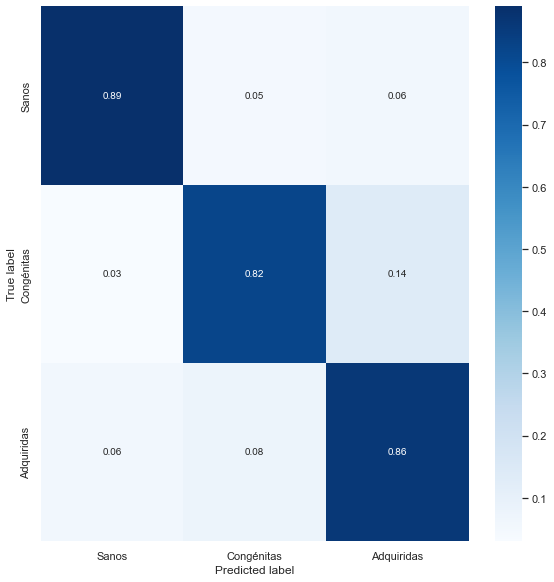

In [19]:
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float')/con_mat.sum(axis=1)[:, np.newaxis],
                         decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names_reduced, columns=class_names_reduced)

print('Accuracy Y_test: ', accuracy_score(y_test, y_pred))
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

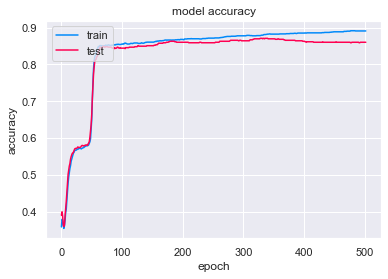

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

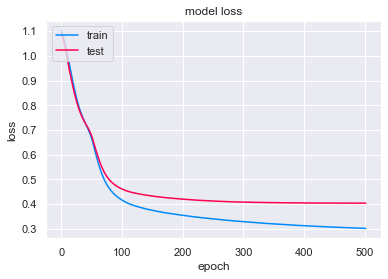

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()